# Revelio Lab

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
import random
from functions.revelio_functions import *
import os
import sys
import re

# Show all columns in pandas
pd.set_option('display.max_columns', 500) 
# Set the display format for float numbers
pd.set_option('display.float_format', '{:,.2f}'.format)

# 0. Merge and import data files

Function "import_data_source" reads all folders and files in a specific directory and creates a dictionary with a single file for each folder within the directory containing all files in said folder. 

In [4]:
print('Individual Data')
individual_files = import_data_source('Data/Individual')

print('\nJob posting Data')
postings_files = import_data_source('Data/Job posting data')

print('\nSentiment Data')
sentiment_files = import_data_source('Data/Sentiment Data')

print('\nWorkforce dynamics Data')
workforce_files = import_data_source('Data/Workforce dynamics')

Individual Data
Folder: individual_education IMPORTED
Folder: individual_position IMPORTED
Folder: individual_skill IMPORTED
Folder: individual_user IMPORTED

Job posting Data
Folder: Job postings linkedin IMPORTED

Sentiment Data
Folder: individual_raw_reviews. - Sentiment IMPORTED

Workforce dynamics Data
Folder: demo_breakdown IMPORTED
Folder: geo_breakdown IMPORTED
Folder: role_breakdown IMPORTED


# 1. Workforce data exploration

In [5]:
# Extract dataframes from workforce dictionary
df_workforce_role = workforce_files['role_breakdown']

df_workforce_geo = workforce_files['geo_breakdown']

df_workforce_demo = workforce_files['demo_breakdown']

## 1.1 Role Breakdown

In [6]:
df_workforce_role.head()

,company,month,rcid,region,seniority,job_category,role_k50,role_k150,count,inflow,outflow,salary,duration
0,Microsoft Corp.,2016-01,350953,Southern America,1,Marketing,Marketing,Digital Marketing Specialist,17.73,3.44,0.00,"166,352.00",1.81
1,Microsoft Corp.,2016-02,350953,Southern America,1,Marketing,Marketing,Digital Marketing Specialist,17.73,0.00,0.00,"166,569.12",1.89
2,Microsoft Corp.,2016-03,350953,Southern America,1,Marketing,Marketing,Digital Marketing Specialist,19.92,2.19,0.00,"188,027.61",1.70
3,Microsoft Corp.,2016-04,350953,Southern America,1,Marketing,Marketing,Digital Marketing Specialist,19.92,0.00,1.15,"188,307.22",1.78
4,Microsoft Corp.,2016-05,350953,Southern America,1,Marketing,Marketing,Digital Marketing Specialist,19.92,1.15,2.20,"186,708.48",1.74


In [7]:
df_workforce_role['company'].unique()

array(['Microsoft Corp.', 'Amazon.com, Inc.', 'Alphabet, Inc.',
       'Apple, Inc.', 'Netflix, Inc.', 'Meta Platforms, Inc.'],
      dtype=object)

### Calculate 3 and 3 month moving averages rates of change (ROC)

In [8]:
# List of columns to calculate the average for
columns_to_average = ['count', 'inflow', 'outflow', 'salary']

# Calculate the average for every month for every company
average_df = df_workforce_role.groupby(['company', 'month'])[columns_to_average].mean().reset_index()

# Calculate 3-month moving average for each column
for column in columns_to_average:
    # Calculate the rolling mean with a window size of 3 and shift to align with the correct month
    average_df[f'{column}_3mma'] = average_df.groupby('company')[column].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
    average_df[f'{column}_12mma'] = average_df.groupby('company')[column].rolling(window=12, min_periods=1).mean().reset_index(level=0, drop=True)

# Calculate the rate of change for the 3-month moving average
for column in columns_to_average:
    # Calculate the percentage change and shift to align with the correct month
    average_df[f'{column}_3mmt_roc'] = average_df.groupby('company')[f'{column}_3mma'].pct_change(12) * 100
    average_df[f'{column}_12mmt_roc'] = average_df.groupby('company')[f'{column}_12mma'].pct_change(12) * 100


average_df.head(20)

,company,month,count,inflow,outflow,salary,count_3mma,count_12mma,inflow_3mma,inflow_12mma,outflow_3mma,outflow_12mma,salary_3mma,salary_12mma,count_3mmt_roc,count_12mmt_roc,inflow_3mmt_roc,inflow_12mmt_roc,outflow_3mmt_roc,outflow_12mmt_roc,salary_3mmt_roc,salary_12mmt_roc
0,"Alphabet, Inc.",2016-01,14.58,0.78,0.33,"909,485.82",14.58,14.58,0.78,0.78,0.33,0.33,"909,485.82","909,485.82",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Alphabet, Inc.",2016-02,14.58,0.33,0.17,"908,089.19",14.58,14.58,0.56,0.56,0.25,0.25,"908,787.51","908,787.51",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Alphabet, Inc.",2016-03,14.74,0.33,0.20,"920,059.11",14.63,14.63,0.48,0.48,0.23,0.23,"912,544.71","912,544.71",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Alphabet, Inc.",2016-04,14.91,0.38,0.19,"932,735.41",14.74,14.70,0.34,0.45,0.19,0.22,"920,294.57","917,592.38",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Alphabet, Inc.",2016-05,15.22,0.50,0.20,"953,284.51",14.95,14.80,0.40,0.46,0.20,0.22,"935,359.68","924,730.81",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"Alphabet, Inc.",2016-06,15.51,0.49,0.23,"974,979.41",15.21,14.92,0.46,0.47,0.21,0.22,"953,666.44","933,105.57",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"Alphabet, Inc.",2016-07,15.68,0.40,0.21,"988,350.05",15.47,15.03,0.46,0.46,0.21,0.22,"972,204.66","940,997.64",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,"Alphabet, Inc.",2016-08,15.86,0.39,0.39,"1,003,557.72",15.68,15.13,0.43,0.45,0.28,0.24,"988,962.39","948,817.65",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"Alphabet, Inc.",2016-09,15.83,0.36,0.32,"1,005,880.24",15.79,15.21,0.38,0.44,0.31,0.25,"999,262.67","955,157.94",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"Alphabet, Inc.",2016-10,15.88,0.37,0.23,"1,012,789.01",15.86,15.28,0.37,0.43,0.31,0.25,"1,007,408.99","960,921.05",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Analyze count rates of change behavior for a single company 

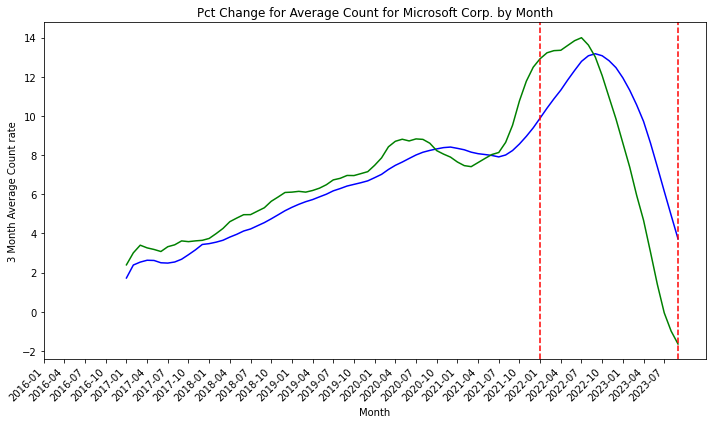

In [9]:
# Visualization: Bar chart for the average count for a specific company
company_to_visualize = 'Microsoft Corp.'

# Filter the DataFrame for the specific company
company_data = average_df[average_df['company'] == company_to_visualize]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.plot(company_data['month'], company_data['count_12mmt_roc'], color='blue')
plt.plot(company_data['month'], company_data['count_3mmt_roc'], color='green')
plt.xlabel('Month')
plt.ylabel('3 Month Average Count rate')
plt.title(f'Pct Change for Average Count for {company_to_visualize} by Month')
plt.xticks(rotation=45, ha='right')

# Display only every nth label to reduce clutter (adjust n as needed)
n = 3
plt.xticks(company_data['month'][::n])

# Add vertical lines at Jan 2022 and Dec 2023
plt.axvline(x='2022-01', color='red', linestyle='--', label='Jan 2022')
plt.axvline(x='2023-09', color='red', linestyle='--', label='Sep 2023')

plt.tight_layout()
plt.show()

### Analyze whole industry ROC for count variable

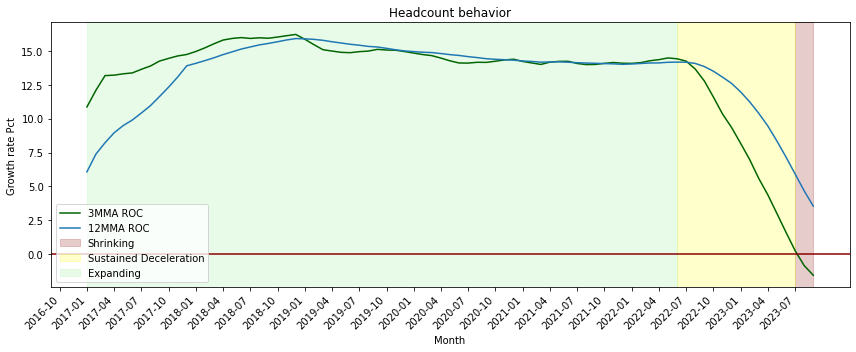

In [28]:
# Visualization: Line plot for the average count for every company
plt.figure(figsize=(12, 5))

# Use Seaborn to create a line plot for every company
sns.lineplot(x='month', y='count_3mmt_roc', data=average_df, label='3MMA ROC', color='darkgreen', ci=None)
sns.lineplot(x='month', y='count_12mmt_roc', data=average_df, label='12MMA ROC', ci=None)

plt.xlabel('Month')
plt.ylabel('Growth rate Pct')
plt.title('Headcount behavior')
plt.xticks(rotation=45, ha='right')

# Display only every nth label to reduce clutter (adjust n as needed)
n = 3
plt.xticks(company_data['month'][::n])

# Add vertical lines at Jan 2022 and Dec 2023
"""
plt.axvline(x='2016-07', color='red', linestyle='--', label='Jan 2022')
plt.axvline(x='2017-07', color='red', linestyle='--', label='Dec 2023')
plt.axvline(x='2018-07', color='red', linestyle='--', label='Dec 2023')
plt.axvline(x='2019-07', color='red', linestyle='--', label='Dec 2023')
plt.axvline(x='2020-07', color='red', linestyle='--', label='Dec 2023')
plt.axvline(x='2021-07', color='red', linestyle='--', label='Dec 2023')
plt.axvline(x='2022-07', color='red', linestyle='--', label='Dec 2023')
"""

plt.axhline(y=0, color='darkred', linestyle='-')

# Shade the region between the vertical lines
plt.axvspan('2023-07', '2023-09', alpha=0.2, color='darkred', label='Shrinking')
# Shade the region between the vertical lines
plt.axvspan('2022-06', '2023-07', alpha=0.2, color='yellow', label='Sustained Deceleration')
# Shade the region between the vertical lines
plt.axvspan('2017-01', '2022-06', alpha=0.2, color='lightgreen', label='Expanding')

plt.legend(loc='lower left')  # Adjust legend position
plt.tight_layout()

# Save plot 
plt.savefig('plots/headcount_roc.png')

plt.show()

In [16]:
df_workforce_geo.head()

,company,month,rcid,region,country,state,metro_area,seniority,job_category,count,inflow,outflow,salary,duration
0,"Alphabet, Inc.",2016-01,766823,Central America and the Caribbean,Panama,Panama,panama metropolitan area,6,Sales,0.00,0.00,0.00,0.00,0.00
1,"Alphabet, Inc.",2016-02,766823,Central America and the Caribbean,Panama,Panama,panama metropolitan area,6,Sales,0.00,0.00,0.00,0.00,0.00
2,"Alphabet, Inc.",2016-03,766823,Central America and the Caribbean,Panama,Panama,panama metropolitan area,6,Sales,0.00,0.00,0.00,0.00,0.00
3,"Alphabet, Inc.",2016-04,766823,Central America and the Caribbean,Panama,Panama,panama metropolitan area,6,Sales,0.00,0.00,0.00,0.00,0.00
4,"Alphabet, Inc.",2016-05,766823,Central America and the Caribbean,Panama,Panama,panama metropolitan area,6,Sales,0.00,0.00,0.00,0.00,0.00


In [17]:
df_workforce_demo.head()

,company,month,rcid,region,seniority,gender,ethnicity,job_category,count,inflow,outflow,salary,duration
0,Microsoft Corp.,2016-01,350953,Arab States,6,Female,White,Scientist,0.76,0.00,0.00,"48,752.24",8.00
1,Microsoft Corp.,2016-02,350953,Arab States,6,Female,White,Scientist,0.76,0.00,0.00,"48,853.28",8.08
2,Microsoft Corp.,2016-03,350953,Arab States,6,Female,White,Scientist,0.76,0.00,0.00,"48,954.56",8.17
3,Microsoft Corp.,2016-04,350953,Arab States,6,Female,White,Scientist,0.76,0.00,0.00,"49,056.07",8.25
4,Microsoft Corp.,2016-05,350953,Arab States,6,Female,White,Scientist,0.76,0.00,0.00,"49,157.80",8.33


# 2 Job posting Data

In [18]:
df_postings = postings_files['Job postings linkedin']

In [19]:
df_postings.to_csv('postings.csv')
df_postings

,job_id,company,country,state,mapped_role,role_k50,role_k150,job_category,salary,post_date,remove_date,rcid,ultimate_parent_rcid,ultimate_parent_company_name,jobtitle_raw,jobtitle_translated
0,3084098752,"Meta Platforms, Inc.",Poland,empty,solutions engineer,Solutions Specialist,Solutions Specialist,Sales,NaN,2022-04-25,2022-06-21,1233178,1233178,"Meta Platforms, Inc.",Technical Solutions Consultant,technical solutions consultant
1,3038829055,Microsoft Corp.,United States,GA,financial planning analysis,Accountant,Financial Analyst,Finance,"121,000.00",2022-04-21,2022-05-21,350953,350953,Microsoft Corp.,Sr. Finance Manager,sr finance manager
2,3032172436,Microsoft Corp.,United States,IN,systems engineering,Software Engineer,Systems Engineer,Engineer,NaN,2022-05-10,2022-05-14,350953,350953,Microsoft Corp.,Strategic Client Technology Leader - Manufactu...,strategic client technology leader manufactu...
3,2881913439,"Meta Platforms, Inc.",Ireland,Dublin,sales operations analyst,Business Operations,Business Operations,Operations,NaN,2022-01-18,2022-01-26,1233178,1233178,"Meta Platforms, Inc.","Market Specialist, Market Operations, Greek",market specialist market operations greek
4,2429967887,"Meta Platforms, Inc.",United States,CA,hr business,Human Resources Specialist,HR Business Partner,Admin,"158,500.00",2021-03-04,2021-04-30,1233178,1233178,"Meta Platforms, Inc.","HR Business Partner, Tech",hr business partner tech
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139239,2992474045,"Meta Platforms, Inc.",France,Île-de-France,security architect,Infrastructure Engineer,Information Security,Engineer,NaN,2022-02-24,2022-03-30,1233178,1233178,"Meta Platforms, Inc.",Lead Counsel-Data Protection (Product),lead counsel data protection product
139240,2787796769,"Meta Platforms, Inc.",United States,empty,test engineering,Application Engineer,Test Engineer,Engineer,NaN,2021-11-09,2022-01-05,1233178,1233178,"Meta Platforms, Inc.",System Validation Engineer,system validation engineer
139241,2893450237,"Meta Platforms, Inc.",United States,WA,scientist i,Quality Assurance,Laboratory Technician,Engineer,NaN,2022-01-26,2022-02-11,1233178,1233178,"Meta Platforms, Inc.","Research Scientist Intern, Inorganic Materials...",research scientist intern inorganic materials ...
139242,2700498554,"Apple, Inc.",United States,CA,visual designer,Designer,UX Designer,Marketing,"193,000.00",2021-09-01,2021-11-14,1232095,1232095,"Apple, Inc.","Senior Art Director, Channel Interactive",senior art director channel interactive


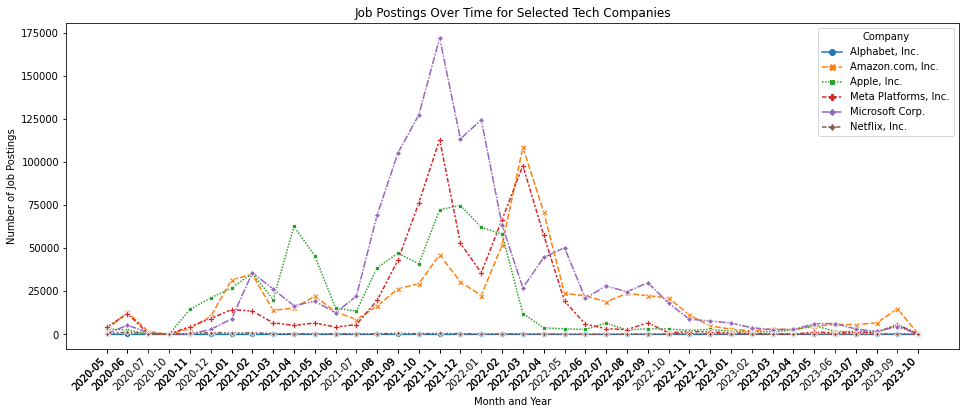

In [27]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Load the data
data = df_postings

# Filter data for specified companies
selected_companies = ['Microsoft Corp.', 'Alphabet, Inc.', 'Apple, Inc.', 'Meta Platforms, Inc.', 'Amazon.com, Inc.', 'Netflix, Inc.']
filtered_data = data[data['company'].isin(selected_companies)]

# Convert 'post_date' to datetime format
filtered_data['post_date'] = pd.to_datetime(filtered_data['post_date'])

# Extract month and year from 'post_date'
filtered_data['Month_Year'] = filtered_data['post_date'].dt.to_period('M').astype(str)

# Group data by month and company to get the count of job postings
job_postings = filtered_data.groupby(['Month_Year', 'company']).size().reset_index(name='Job_Postings')

# Pivot the data for better visualization
job_postings_pivot = job_postings.pivot(index='Month_Year', columns='company', values='Job_Postings').fillna(0)

# Plotting the data
plt.figure(figsize=(16, 6))
sns.lineplot(data=job_postings_pivot, markers=True)
plt.title('Job Postings Over Time for Selected Tech Companies')
plt.xlabel('Month and Year')
# Display only every nth label to reduce clutter (adjust n as needed)
n = 3
plt.xticks(job_postings['Month_Year'][::n])
# Rotate ticks
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Job Postings')
plt.legend(title='Company')
plt.show()

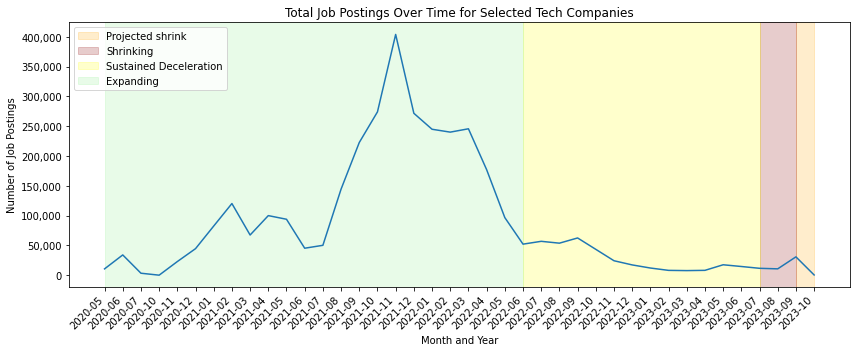

In [29]:
# Load the data
data = df_postings

# Filter data for specified companies
selected_companies = ['Microsoft Corp.', 'Alphabet, Inc.', 'Apple, Inc.', 'Meta Platforms, Inc.', 'Amazon.com, Inc.', 'Netflix, Inc.']
filtered_data = data[data['company'].isin(selected_companies)]

# Convert 'post_date' to datetime format
filtered_data['post_date'] = pd.to_datetime(filtered_data['post_date'])

# Extract month and year from 'post_date'
filtered_data['Month_Year'] = filtered_data['post_date'].dt.to_period('M').astype(str)

# Group data by month to get the count of job postings for all companies
total_job_postings = filtered_data.groupby('Month_Year').size().reset_index(name='Total_Job_Postings')

# Plotting the data
plt.figure(figsize=(12, 5))
sns.lineplot(data=total_job_postings, x='Month_Year', y='Total_Job_Postings')

# Shade the region between the vertical lines
plt.axvspan('2023-09', '2023-10', alpha=0.2, color='orange', label='Projected shrink')
# Shade the region between the vertical lines
plt.axvspan('2023-07', '2023-09', alpha=0.2, color='darkred', label='Shrinking')
# Shade the region between the vertical lines
plt.axvspan('2022-06', '2023-07', alpha=0.2, color='yellow', label='Sustained Deceleration')
# Shade the region between the vertical lines
plt.axvspan('2020-05', '2022-06', alpha=0.2, color='lightgreen', label='Expanding')


plt.title('Total Job Postings Over Time for Selected Tech Companies')
plt.xlabel('Month and Year')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Job Postings')
plt.legend()  # Adjust legend position

plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.tight_layout()

# Save plot 
plt.savefig('plots/postings.png')

plt.show()


In [22]:
# Extract sentiment dataframe
df_sentment = sentiment_files['individual_raw_reviews. - Sentiment']

df_sentment.head(3)

,rcid,company_id,company,review_id,review_language_id,location_raw,region,country,state,metro_area,job_title_raw,mapped_role,job_category,review_date_time,review_iscovid19,reviewer_employment_status,reviewer_job_ending_year,reviewer_length_of_employment,reviewer_current_job,rating_overall,rating_business_outlook,rating_career_opportunities,rating_ceo,rating_compensation_and_benefits,rating_culture_and_values,rating_diversity_and_inclusion,rating_recommend_to_friend,rating_senior_leadership,rating_work_life_balance,review_summary,review_advice,review_pros,review_cons,review_count_helpful,review_count_not_helpful,ultimate_parent_rcid,ultimate_parent_company_name
0,1359692,6036,"Amazon.com, Inc.",77161736,eng,NaN,empty,empty,empty,empty,Software Development Engineer (SDE),software engineering,Engineer,2023-06-07 10:41:04.723,False,REGULAR,NaN,NaN,True,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Too much work,NaN,Good salary and the office is pretty nice too,Bad work hours Not many benefits,NaN,NaN,1359692,"Amazon.com, Inc."
1,350953,1651,Microsoft Corp.,7780164,eng,NaN,empty,empty,empty,empty,Hardware Engineer,hardware engineer,Engineer,2015-08-30 20:11:46.147,False,REGULAR,"2,015.00",2.00,False,4,POSITIVE,3.00,NO_OPINION,2.00,3.00,NaN,POSITIVE,3.00,4.00,Nice place to work,Try to be more flexible in benefit compensation,Working with very friendly and nice colleagues...,Salary is not very good and low increase. They...,NaN,NaN,350953,Microsoft Corp.
2,22142809,422,"Whole Foods Market, Inc.",39650796,eng,NaN,empty,empty,empty,empty,Supervisor,floor,Sales,2020-12-20 08:36:43.953,False,REGULAR,NaN,4.00,True,3,NEGATIVE,1.00,APPROVE,4.00,2.00,4.00,NEGATIVE,1.00,1.00,"Decent pay, benefits. Way too PC",NaN,"Good benefits, decent pay, discount","It's so plotically correct, you will be passed...",NaN,NaN,1359692,"Amazon.com, Inc."


### Wordcloud

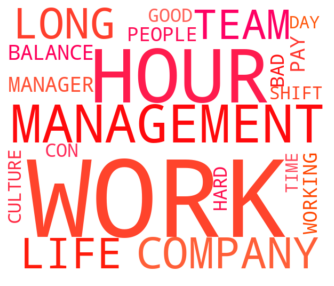

In [36]:
create_word_cloud(df_sentment, 'review_cons', sentiment='negative')

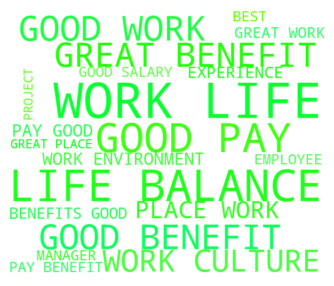

In [37]:
create_word_cloud(df_sentment, 'review_pros', sentiment='positive')

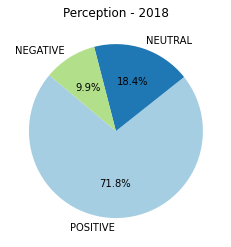

In [51]:
# Filter data for specified companies
selected_companies = ['Microsoft Corp.', 'Alphabet, Inc.', 'Apple, Inc.', 'Meta Platforms, Inc.', 'Amazon.com, Inc.', 'Netflix, Inc.']
df = df_sentment[df_sentment['company'].isin(selected_companies)]

# Filter for time of interest
df = df[(df['review_date_time'] >= '2017-12-01') & (df['review_date_time'] <= '2018-12-31')]

# Create a DataFrame with the distribution of 'rating_business_outlook'
rating_distribution = df['rating_business_outlook'].value_counts(normalize=True).reset_index()
rating_distribution.columns = ['Rating', 'Percentage']

# Plot the percentage distribution as a pie chart
plt.figure(figsize=(4, 4))
plt.pie(rating_distribution['Percentage'] * 100, labels=rating_distribution['Rating'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Perception - 2018')

plt.savefig('plots/opinions_2018')
plt.show()

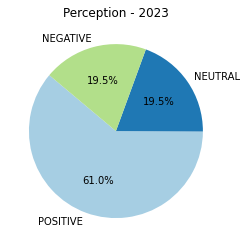

In [52]:
# Filter data for specified companies
selected_companies = ['Microsoft Corp.', 'Alphabet, Inc.', 'Apple, Inc.', 'Meta Platforms, Inc.', 'Amazon.com, Inc.', 'Netflix, Inc.']
df = df_sentment[df_sentment['company'].isin(selected_companies)]

# Filter for time of interest
df = df[(df['review_date_time'] >= '2022-12-01') & (df['review_date_time'] <= '2023-12-31')]

# Create a DataFrame with the distribution of 'rating_business_outlook'
rating_distribution = df['rating_business_outlook'].value_counts(normalize=True).reset_index()
rating_distribution.columns = ['Rating', 'Percentage']

# Plot the percentage distribution as a pie chart
plt.figure(figsize=(4, 4))
plt.pie(rating_distribution['Percentage'] * 100, labels=rating_distribution['Rating'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Perception - 2023')

plt.savefig('plots/opinions_2023')
plt.show()